# Gene Scores

Gene score plots at a fine grained cluster level. Inputs:

1. `metadata.tsv` with UMAP/densMAP coordinates and total fragments/insertions.
2. `features.10d.tsv` scATAC-seq features for kNN smoothing
3. ArchR gene scores

In [55]:
library(Matrix)
library(ggplot2)
library(patchwork)
library(GenomicRanges)
library(scales)
library(RColorBrewer)
library(DESeq2)
library(rtracklayer)
library(Seurat)
library(ArchR)
library(RANN)
library(scattermore)

In [2]:
DAYS = c("D0", "D2", "D4", "D6", "D8", "D10", "D12", "D14", "iPSC")

## Loading Inputs

### MetaData

In [3]:
# should contain, sample_barcode as rowname, sample, umap1, umap2, cluster
metaData = read.table("../analysis/20200206_pmat_snapATAC/sessions/20210717_n62599//metadata.tsv", header = T)
rownames(metaData) = paste(metaData$sample, metaData$barcode, sep='_')
metaData$sample = factor(metaData$sample, levels=DAYS)
dim(metaData)
head(metaData, 5)

[1] 62599     5

,barcode,sample,umap1,umap2,cluster
,<fct>,<fct>,<dbl>,<dbl>,<int>
D0_AAACACGCTAGTACGG,AAACACGCTAGTACGG,D0,-1.8037916,-9.507773,1
D0_AAACACGCTCTTCAAG,AAACACGCTCTTCAAG,D0,0.7074551,-9.406457,1
D0_AAACACGCTGATCCAT,AAACACGCTGATCCAT,D0,-2.9559933,-7.641148,1
D0_AAACCCTGACCGCTAG,AAACCCTGACCGCTAG,D0,-3.6119107,-8.443144,1
D0_AAACCCTGATTGCAGT,AAACCCTGATTGCAGT,D0,0.5002119,-8.759449,3


In [16]:
# will use feature to construct kNN graph for smoothing
features = read.table("../analysis/20200206_pmat_snapATAC/sessions/20210717_n62599/features.10d.tsv", header = T)
rownames(features) = features$sample_barcode
features$sample_barcode = NULL 
dim(features)
head(features, 5)

[1] 62599    10

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
D0_AAACACGCTAGTACGG,-0.011152076,0.004344354,0.0002529584,0.008401771,8.648427e-03,0.010894021,-0.0094426710,0.007332589,-0.0010194442,0.004179675
D0_AAACACGCTCTTCAAG,-0.009687992,0.003813404,-0.0019580142,0.002899934,6.726516e-03,0.021007651,-0.0007418293,0.004306952,0.0009223041,0.002109996
D0_AAACACGCTGATCCAT,-0.010974599,0.003615655,0.0003501312,0.004525435,1.075582e-03,0.001667028,-0.0094977661,0.004310447,-0.0050801545,0.004722692
D0_AAACCCTGACCGCTAG,-0.014855187,0.004356973,0.0036240332,0.007491073,-6.718933e-05,0.003827929,-0.0135600675,0.006657502,0.0011535875,0.009558255
D0_AAACCCTGATTGCAGT,-0.012246358,0.004827133,0.0014392929,0.005282205,8.118169e-03,0.015956554,-0.0007619940,-0.004423390,0.0028289789,0.004031496


## ArchR Gene Scores

In [5]:
addArchRThreads(threads = 32) 

Setting default number of Parallel threads to 32.



In [6]:
addArchRGenome("hg38")

Setting default genome to Hg38.



In [7]:
ArrowFiles = paste(DAYS, "arrow", sep='.')
ArrowFiles

[1] "D0.arrow"   "D2.arrow"   "D4.arrow"   "D6.arrow"   "D8.arrow"  
[6] "D10.arrow"  "D12.arrow"  "D14.arrow"  "iPSC.arrow"

In [8]:
archr_proj <- ArchRProject(
  ArrowFiles = paste("/srv/scratch/surag/scATAC-reprog/arrow/", ArrowFiles, sep=''), 
  outputDirectory = "./tmp/",
  copyArrows = FALSE #This is recommened so that you maintain an unaltered copy for later usage.
)

Using GeneAnnotation set by addArchRGenome(Hg38)!

Using GeneAnnotation set by addArchRGenome(Hg38)!

Validating Arrows...

Getting SampleNames...



Getting Cell Metadata...



Merging Cell Metadata...

Initializing ArchRProject...


                                                   / |
                                                 /    \
            .                                  /      |.
            \\\                              /        |.
              \\\                          /           `|.
                \\\                      /              |.
                  \                    /                |\
                  \\#####\           /                  ||
                ==###########>      /                   ||
                 \\##==......\    /                     ||
            ______ =       =|__ /__                     ||      \\\
        ,--' ,----`-,__ ___/'  --,-`-===================##========>
       \               '        ##_______ _____ ,-

In [9]:
all(paste(metaData$sample, metaData$barcode, sep='#') %in% archr_proj$cellNames)

[1] TRUE

In [10]:
# subset to cells
archr_proj = archr_proj[paste(metaData$sample, metaData$barcode, sep='#'), ]

In [11]:
getAvailableMatrices(archr_proj)

[1] "GeneScoreMatrix" "TileMatrix"

In [12]:
archr_gene_score = getMatrixFromProject(archr_proj, "GeneScoreMatrix")
dim(archr_gene_score)

ArchR logging to : ArchRLogs/ArchR-getMatrixFromProject-37495d5909715b-Date-2021-08-01_Time-22-57-59.log
If there is an issue, please report to github with logFile!

2021-08-01 22:59:37 : Organizing colData, 1.639 mins elapsed.

2021-08-01 22:59:37 : Organizing rowData, 1.642 mins elapsed.

2021-08-01 22:59:37 : Organizing rowRanges, 1.642 mins elapsed.

2021-08-01 22:59:37 : Organizing Assays (1 of 1), 1.642 mins elapsed.

2021-08-01 23:00:47 : Constructing SummarizedExperiment, 2.812 mins elapsed.

2021-08-01 23:00:49 : Finished Matrix Creation, 2.837 mins elapsed.



[1] 24919 62599

In [13]:
archr_gene_score_mat = archr_gene_score@assays@data$GeneScoreMatrix
rownames(archr_gene_score_mat) = rowData(archr_gene_score)$name
colnames(archr_gene_score_mat) = sub("#", "_", rownames(colData(archr_gene_score)))
# reorder
archr_gene_score_mat = archr_gene_score_mat[, rownames(metaData)]

In [14]:
# reclaim some memory
rm(archr_gene_score)
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,8469597,452.4,15447537,825.0,12213087,652.3
Vcells,881125681,6722.5,2586106100,19730.5,3380997490,25795.0


## Smoothed Gene Scores

In [47]:
K = 15 

In [30]:
knn = nn2(features, k=K)

In [38]:
j <- as.numeric(x = t(x = knn$nn.idx))
i <- ((1:length(x = j)) - 1) %/% K + 1	
edgeList = data.frame(i, j, 1);

In [39]:
knng = sparseMatrix(i = edgeList[,1], j = edgeList[,2], x = edgeList[,3]);

In [50]:
# clip and smooth
top = 
archr_gene_score_mat_smoothed = 1/K * (archr_gene_score_mat %*% knng)
archr_gene_score_mat_smoothed = as.matrix(archr_gene_score_mat_smoothed)

## Plotting

In [256]:
GENE="CDH1"

In [257]:
cur_gene_score = as.numeric(archr_gene_score_mat[GENE,])

In [258]:
# clip and smooth
Q = 0.98
cur_gene_score[cur_gene_score>quantile(cur_gene_score, Q)] = quantile(cur_gene_score, Q)
cur_gene_score = as.vector(1/K * (knng%*% cur_gene_score))

In [259]:
df = data.frame(umap1=metaData$umap1, 
                umap2=metaData$umap2,
                gene_score=cur_gene_score)
# shuffle so days don't overlap
df = df[sample(dim(df)[1], 25000), ]


gs_plot <- ggplot(df) +
# ggplot(df[df$x.sp.sample %in% c("D14"), ]) +
geom_scattermore(pointsize=3, aes(x=umap1 , y=umap2, col=gene_score), pixels=c(1000,1000)) +
# ggtitle(sub("-2[0-9]+", "",GENE)) + 
scale_color_viridis_c(option = "D", 
                      limits= c(quantile(cur_gene_score, 0.1),
                               quantile(cur_gene_score, 0.9)),
                      oob=squish,
                      name="Gene\nScore") +
theme_classic() +
    xlab("UMAP 1") + ylab("UMAP 2") +
    theme(plot.title = element_text(hjust = 0.5),
          text = element_text(size=12),
          axis.line=element_blank(),
          axis.text.x=element_blank(),
          axis.text.y=element_blank(),
          axis.ticks=element_blank(),
          legend.text = element_blank(), # no numbers
          panel.border = element_rect(colour = "black", fill=NA, size=0.5)) +
    coord_fixed()

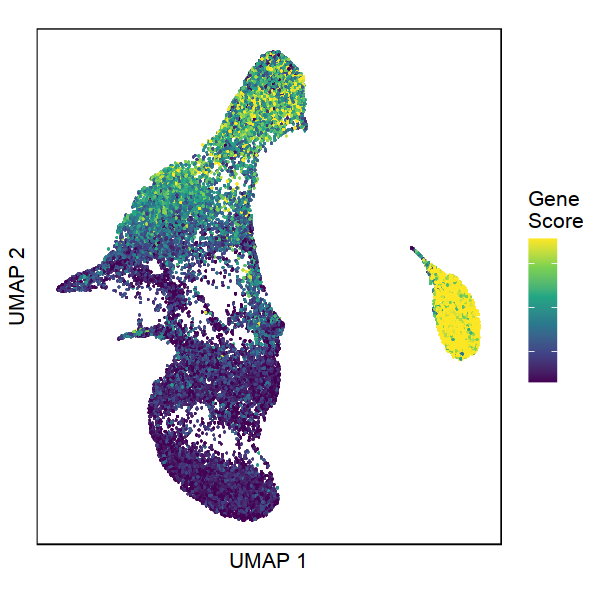

In [260]:
options(repr.plot.width = 5, repr.plot.height = 5)

gs_plot

In [261]:
saveRDS(gs_plot, file=sprintf("./Fig1/subfigs/%s_%s_gs.rds",
                                   format(Sys.Date(), "%Y%m%d"), GENE))

---

In [ ]:
sessionInfo()